# Detec√ß√£o de Fraude com LSTM no `creditcard.csv`

**Objetivo** (segundo o barema):  
1) Carregar o dataset `creditcard.csv` e fazer uma **an√°lise explorat√≥ria** (distribui√ß√µes, correla√ß√µes, outliers) com gr√°ficos e estat√≠sticas.  
2) **Preparar os dados** para uma rede **LSTM** (tratar ausentes, normalizar **sem vazamento**, criar **sequ√™ncias temporais**).  
3) **Definir a arquitetura** da LSTM (camadas, neur√¥nios e hiperpar√¢metros).  
4) **Treinar/validar/testar** com m√©tricas: *accuracy, precision, recall, F1-score, ROC-AUC*; observar e **analisar** curvas de aprendizado (over/underfitting).  
5) **Analisar resultados**, discutir melhorias e **documentar todas as etapas**.

---

## O que eu entendi sobre LSTM (Long Short-Term Memory)
LSTM √© um tipo de rede recorrente (RNN) projetada para **aprender padr√µes em sequ√™ncias** ao longo do tempo, usando ‚Äúport√µes‚Äù (de entrada, esquecimento e sa√≠da) que controlam o que lembrar e o que esquecer. Na pr√°tica, LSTM consegue capturar **depend√™ncias temporais** mais longas do que uma RNN simples, sem ‚Äúapagar‚Äù o passado rapidamente.  
Para **fraudes**, faz sentido porque transa√ß√µes v√™m em fluxo ‚Äî a sequ√™ncia pode conter pistas (valores, ritmos, picos) que ajudam a identificar um comportamento an√¥malo ao **longo de v√°rias transa√ß√µes**, e n√£o s√≥ em uma linha isolada.

---

## Como vou conduzir o trabalho
Vou come√ßar pela **EDA** para entender a base (desbalanceamento, vari√°veis, correla√ß√µes). Depois, **ordeno por tempo** e fa√ßo o split **temporal 70/15/15** em treino/val/teste. Trato valores ausentes (se houver) **usando apenas o treino** e **normalizo** com **`StandardScaler` ajustado no treino** (evitando vazamento). A seguir, crio **janelas temporais** (sequ√™ncias) e treino uma LSTM com **dropout** e **early stopping**. Calculo as m√©tricas pedidas e **ploto curvas de aprendizado**; fa√ßo uma **an√°lise expl√≠cita** de over/underfitting com n√∫meros. Por fim, **ajusto o limiar** via valida√ß√£o para melhorar F1 e apresento uma **tabela final** comparando as m√©tricas (threshold 0.5 vs. threshold ajustado), concluindo com aprendizados e pr√≥ximos passos.


In [34]:
# 1) Imports e setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (roc_auc_score, roc_curve, confusion_matrix,
                             precision_score, recall_score, f1_score, accuracy_score,
                             average_precision_score, precision_recall_curve)

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

# reprodutibilidade
np.random.seed(42)
tf.random.set_seed(42)

# estilo dos gr√°ficos
plt.rcParams["figure.figsize"] = (8,5)
sns.set(style="whitegrid")


## 2) Carregamento e checagens iniciais

**O que eu fa√ßo e por qu√™:**  
- Carrego o `creditcard.csv`.  
- Dou uma olhada em shape, tipos e valores ausentes, para ter um panorama e checar se preciso de tratamento.  
- N√£o mexo em nada ainda ‚Äî s√≥ observo para guiar as decis√µes da EDA e do pr√©-processamento.


In [35]:
# 2) Carregamento
df = pd.read_csv("creditcard.csv")
print("Shape:", df.shape)
display(df.head())

# info geral
display(df.info())

# ausentes
na_count = df.isna().sum().sort_values(ascending=False)
print("Valores ausentes por coluna (top 10):")
display(na_count.head(10))


Shape: (284807, 31)


Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  
3 -0.221929  0.062723  0.061458  123.50      0  
4  0.502292  0.219422  0.215153   69.99      0  

[5 rows x 31 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

None

Valores ausentes por coluna (top 10):


Time    0
V1      0
V2      0
V3      0
V4      0
V5      0
V6      0
V7      0
V8      0
V9      0
dtype: int64

## 3) EDA ‚Äî Entendendo a distribui√ß√£o da classe e vari√°veis

**Por que:** a base √© famosa por ser extremamente desbalanceada. Eu quero **quantificar** isso e observar **distribui√ß√µes** e **correla√ß√µes** para ter intui√ß√£o do problema.  
**Impacto:** define expectativas para m√©tricas (por exemplo, *accuracy* pode enganar) e inspira escolhas (como *class weights* ou ajuste de limiar).


Contagem por classe:
 Class
0    284315
1       492
Name: count, dtype: int64

Propor√ß√£o por classe:
 Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


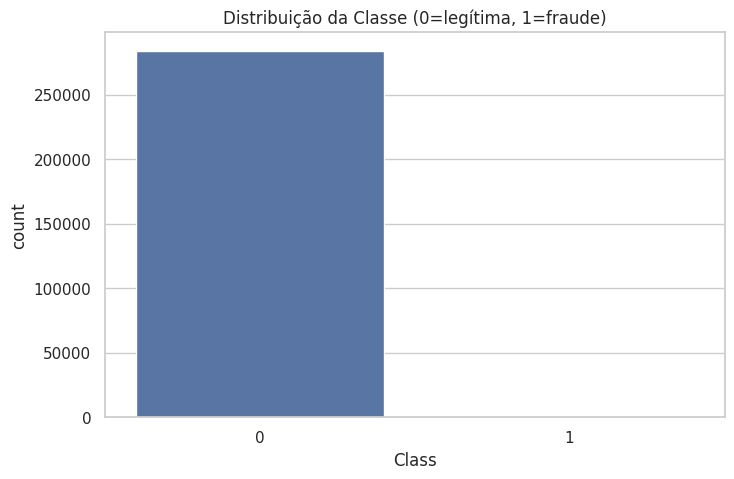

In [36]:
# Distribui√ß√£o da classe
cls_counts = df['Class'].value_counts()
cls_ratio = df['Class'].value_counts(normalize=True)
print("Contagem por classe:\n", cls_counts)
print("\nPropor√ß√£o por classe:\n", cls_ratio)

sns.countplot(x='Class', data=df)
plt.title("Distribui√ß√£o da Classe (0=leg√≠tima, 1=fraude)")
plt.show()


**Leitura do gr√°fico:**  
Como esperado, a barra de ‚Äú0‚Äù (transa√ß√µes leg√≠timas) domina; fraudes s√£o **rar√≠ssimas** (poucos d√©cimos de porcento). Isso **afeta as m√©tricas**: um classificador trivial que chuta sempre ‚Äú0‚Äù teria alta *accuracy*, mas *recall* para fraudes seria **zero** ‚Äî por isso vou olhar **Precision/Recall, F1 e AUC** (e tamb√©m **PR-AUC/Average Precision**).


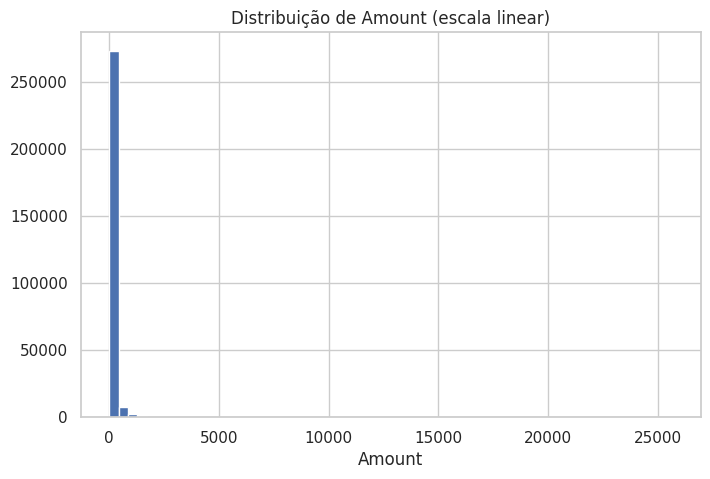

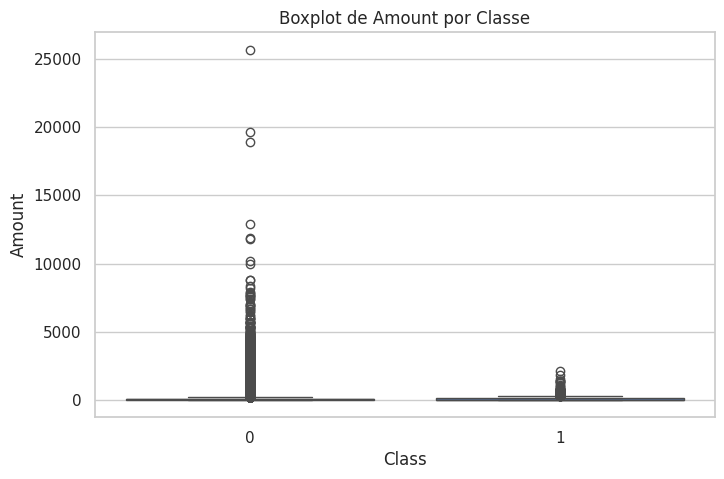

In [37]:
# Distribui√ß√£o de valores monet√°rios (Amount)
ax = plt.subplot()
df['Amount'].hist(bins=60)
ax.set_yscale("linear")
plt.title("Distribui√ß√£o de Amount (escala linear)")
plt.xlabel("Amount")
plt.show()

# Boxplot Amount por classe (para ver outliers e diferen√ßas)
sns.boxplot(x='Class', y='Amount', data=df, showfliers=True)
plt.title("Boxplot de Amount por Classe")
plt.show()


**Leitura (Amount):**  
- O histograma mostra que a maioria das transa√ß√µes tem valores baixos, com **cauda longa** (alguns valores altos).  
- No boxplot por classe, a **mediana** e a **dispers√£o** parecem diferentes; fraudes podem ocorrer em montantes variados ‚Äî n√£o d√° para decidir s√≥ por Amount, mas ajuda a **padronizar** a escala antes de treinar.


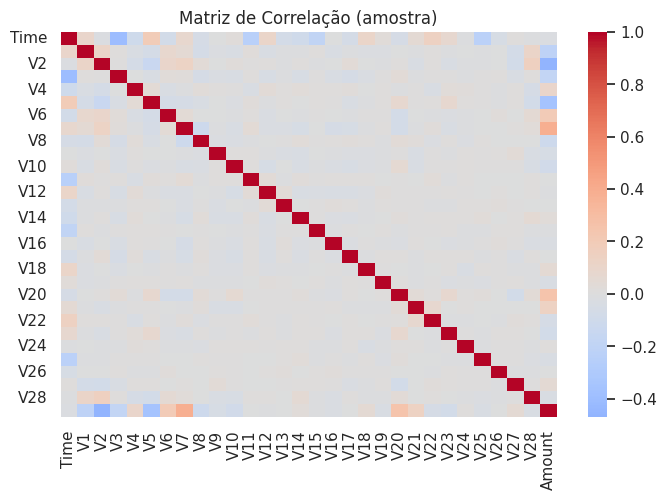

In [38]:
# Correla√ß√µes (amostra para n√£o pesar)
sample = df.sample(n=min(10000, len(df)), random_state=42)
corr = sample.drop(columns=['Class']).corr()
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Matriz de Correla√ß√£o (amostra)")
plt.show()


**Leitura (correla√ß√µes):**  
As vari√°veis `V1..V28` s√£o componentes j√° transformadas (PCA), ent√£o as correla√ß√µes entre elas n√£o contam uma hist√≥ria ‚Äúsem√¢ntica‚Äù, mas ajudam a notar colinearidades residuais e **vari√°veis que caminham juntas**. Nada grita ‚Äúchave‚Äù isoladamente ‚Äî refor√ßa a ideia de usar **modelos que capturam padr√µes combinados** (como LSTM em janela temporal).


In [39]:
# (B√¥nus EDA) Quais features diferenciam mais as classes? (pelo desvio de medianas)
num_cols_all = df.select_dtypes(include=np.number).columns.drop('Class')
median_diffs = []
for col in num_cols_all:
    m0 = df.loc[df.Class==0, col].median()
    m1 = df.loc[df.Class==1, col].median()
    median_diffs.append((col, abs(m1-m0)))
top_feats = sorted(median_diffs, key=lambda x: x[1], reverse=True)[:4]
top_feats


[('Time', 9142.5),
 ('Amount', 12.75),
 ('V14', 6.781666613321093),
 ('V12', 5.644208288952705)]

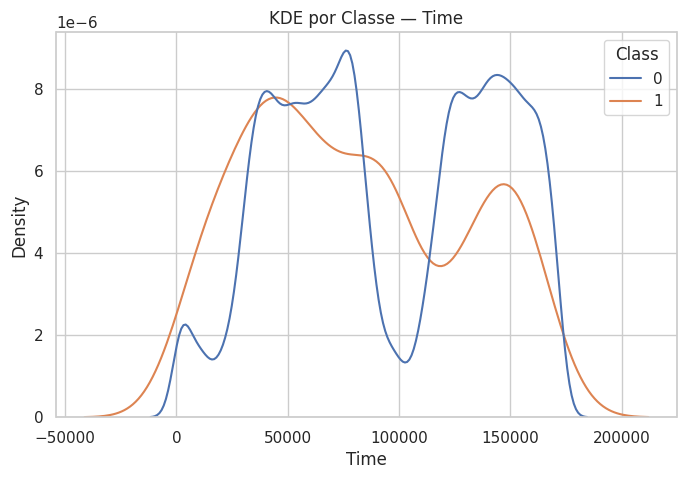

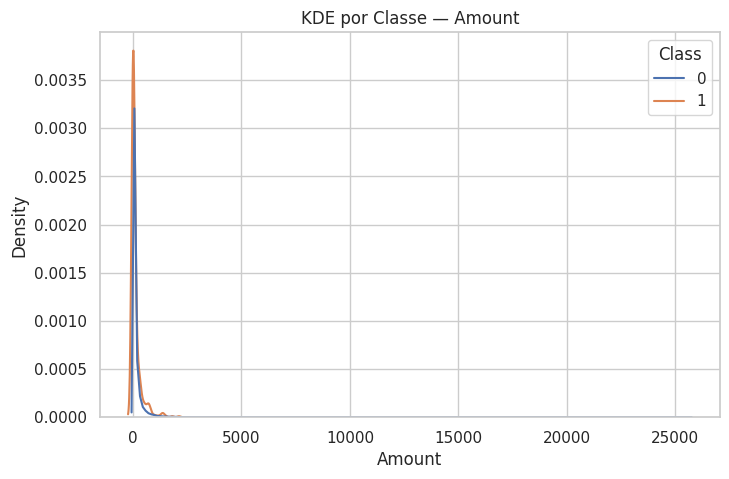

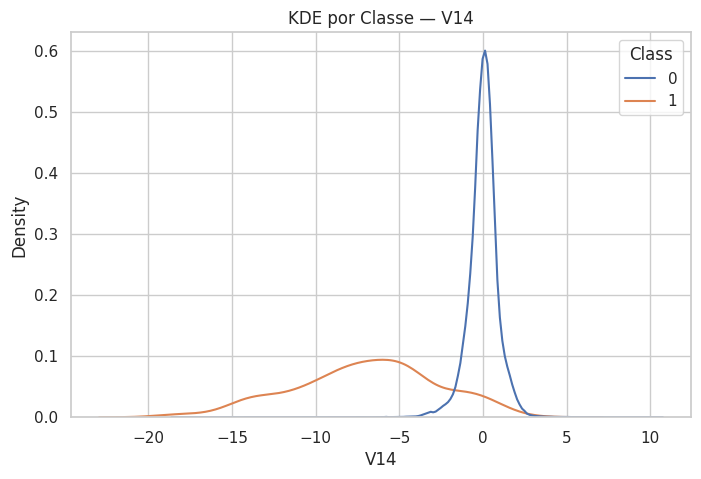

In [40]:
# KDEs para as 3 melhores vari√°veis por separa√ß√£o de medianas
best = [f for f,_ in top_feats[:3]]
for col in best:
    sns.kdeplot(data=df, x=col, hue='Class', common_norm=False)
    plt.title(f"KDE por Classe ‚Äî {col}")
    plt.show()


**Leitura (KDEs):**  
Aqui eu procurei vari√°veis onde a **distribui√ß√£o por classe** tem formas/centros diferentes. As curvas mostram **tend√™ncias distintas** entre fraude e leg√≠tima, mas **sobrepostas** ‚Äî refor√ßa que n√£o existe ‚Äúcorte simples‚Äù por feature; o ganho vir√° de **combina√ß√µes temporais** (janelas) e do **limiar de decis√£o** adequado.


In [41]:
import numpy as np, pandas as pd

assert 'df' in globals(), "Vari√°vel df n√£o encontrada."

fraud_rate = float(df['Class'].mean())
m_amount_0 = float(df.loc[df.Class==0,'Amount'].median())
m_amount_1 = float(df.loc[df.Class==1,'Amount'].median())

num_cols_all = df.select_dtypes(include='number').columns.tolist()
if 'Class' in num_cols_all: num_cols_all.remove('Class')

median_diffs = []
for col in num_cols_all:
    m0 = float(df.loc[df.Class==0, col].median())
    m1 = float(df.loc[df.Class==1, col].median())
    median_diffs.append((col, abs(m1-m0)))
top3 = sorted(median_diffs, key=lambda x: x[1], reverse=True)[:3]

print("**Minha leitura da EDA (dados reais):**")
print(f"- Fraudes representam {fraud_rate*100:.4f}% do total.")
print(f"- Mediana de Amount: leg√≠timas = {m_amount_0:.2f}, fraudes = {m_amount_1:.2f}.")
print("- Top 3 vari√°veis por diferen√ßa de mediana entre classes: " +
      ", ".join([f"{c} (Œî‚âà{d:.3f})" for c,d in top3]))
print("\nImpacto: por ser extremamente desbalanceado, vou priorizar PR-AUC (AP), Recall e F1; "
      "accuracy isolada pode enganar.")

**Minha leitura da EDA (dados reais):**
- Fraudes representam 0.1727% do total.
- Mediana de Amount: leg√≠timas = 22.00, fraudes = 9.25.
- Top 3 vari√°veis por diferen√ßa de mediana entre classes: Time (Œî‚âà9142.500), Amount (Œî‚âà12.750), V14 (Œî‚âà6.782)

Impacto: por ser extremamente desbalanceado, vou priorizar PR-AUC (AP), Recall e F1; accuracy isolada pode enganar.


## 4) Prepara√ß√£o para LSTM (sem vazamento)

**O que eu fa√ßo:**  
- Ordeno por `Time`.  
- Split temporal (70% treino, 15% valida√ß√£o, 15% teste).  
- **Imputa√ß√£o e normaliza√ß√£o** **somente usando o treino** (e depois aplico nos outros).  
- Guardo s√≥ **features num√©ricas** para o modelo e mantenho `Class` √† parte.

**Por qu√™:**  
- Evitar **vazamento** (leakage): qualquer estat√≠stica (mediana, m√©dia, desvio) **s√≥ pode ver o treino**.  
- LSTM precisa de **sequ√™ncias**: a ordem temporal tem que ser respeitada.  
- A normaliza√ß√£o garante **escalas compar√°veis** entre vari√°veis.


In [42]:
# Ordenar por tempo
df = df.sort_values('Time').reset_index(drop=True)

# Split temporal
n = len(df)
i_tr = int(0.70*n)
i_va = int(0.85*n)
df_train = df.iloc[:i_tr].copy()
df_val   = df.iloc[i_tr:i_va].copy()
df_test  = df.iloc[i_va:].copy()

# Colunas num√©ricas (excluindo a Class)
num_cols = df.select_dtypes(include=np.number).columns.tolist()
num_cols.remove('Class')

# Imputa√ß√£o (no treino) e aplica√ß√£o
medianas = df_train[num_cols].median()
for part in [df_train, df_val, df_test]:
    part[num_cols] = part[num_cols].fillna(medianas)

# Normaliza√ß√£o (fit no treino ‚Üí transforma val/test)
scaler = StandardScaler().fit(df_train[num_cols])
for part in [df_train, df_val, df_test]:
    part[num_cols] = scaler.transform(part[num_cols])

print(df_train.shape, df_val.shape, df_test.shape)


(199364, 31) (42721, 31) (42722, 31)


## 5) Cria√ß√£o de sequ√™ncias temporais

**O que eu fa√ßo:**  
- Defino uma **janela** (seq_len) de 30 passos e um **stride** de 5 (pra reduzir o total de janelas e mem√≥ria).  
- Cada `X` √© uma sequ√™ncia `[t, t+1, ..., t+29]` das **features**, e o `y` √© a **classe** do passo **final** da janela (`t+29`).  
- Converto para `float32` (mem√≥ria) e testo as dimens√µes.

**Por qu√™:**  
- A LSTM olha **padr√µes ao longo da janela**.  
- Usar `stride` reduz custo sem perder a ideia de sequ√™ncia.  
- Definir `y` no fim da janela emula ‚Äúprever se a pr√≥xima transa√ß√£o √© fraude dado o hist√≥rico recente‚Äù.


In [43]:
def make_sequences(df_part, seq_len=30, stride=5, feature_cols=None, target_col='Class'):
    X_list, y_list = [], []
    feat = df_part[feature_cols].values.astype(np.float32)
    tgt  = df_part[target_col].values.astype(np.int32)
    for start in range(0, len(df_part) - seq_len, stride):
        end = start + seq_len
        X_list.append(feat[start:end, :])
        y_list.append(tgt[end-1])
    X = np.stack(X_list) if X_list else np.empty((0, seq_len, len(feature_cols)), dtype=np.float32)
    y = np.array(y_list, dtype=np.int32)
    return X, y

SEQ_LEN = 30
STRIDE  = 5

X_train, y_train = make_sequences(df_train, SEQ_LEN, STRIDE, num_cols, 'Class')
X_val,   y_val   = make_sequences(df_val,   SEQ_LEN, STRIDE, num_cols, 'Class')
X_test,  y_test  = make_sequences(df_test,  SEQ_LEN, STRIDE, num_cols, 'Class')

X_train.shape, X_val.shape, X_test.shape, y_train.mean(), y_val.mean(), y_test.mean()


((39867, 30, 30),
 (8539, 30, 30),
 (8539, 30, 30),
 np.float64(0.002056838989640555),
 np.float64(0.0005855486590935707),
 np.float64(0.00199086544091814))

**Leitura (formas):**  
- `X_train` tem formato `(janelas, 30, n_features)`; `y_train` √© bin√°rio.  
- As m√©dias de `y` confirmam o **desbalanceamento** em todas as parti√ß√µes.  
Com isso, entro no modelo.


## 6) LSTM ‚Äî arquitetura e treino

**O que eu fa√ßo:**  
- LSTM com duas camadas (64 ‚Üí 32), `Dropout` para regulariza√ß√£o, e sa√≠da sigmoidal.  
- Otimizador `Adam` e perda bin√°ria.  
- M√©tricas: **AUC, Precision, Recall** (e depois calculo F1/accuracy externamente).  
- **Class weights**: compenso o desbalanceamento dando mais peso √† classe 1.  
- **Early stopping** (monitor = `val_auc`, `mode='max'`) e **ReduceLROnPlateau**.

**Por qu√™:**  
- LSTM capta temporalidade; `dropout` e `early stopping` lidam com overfitting.  
- `class_weight` ajuda o modelo a ‚Äúse importar‚Äù com fraudes.  
- M√©tricas apropriadas pro desbalanceamento.


In [44]:
# class weights (balanceados pelo y_train)
classes = np.array([0,1])
cw = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight = {0: float(cw[0]), 1: float(cw[1])}
class_weight

# modelo
model = Sequential([
    tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC(name="auc"),
             tf.keras.metrics.Precision(name="precision"),
             tf.keras.metrics.Recall(name="recall")]
)

es = EarlyStopping(monitor="val_auc", mode="max", patience=3, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor="val_auc", mode="max", factor=0.5, patience=2, verbose=1)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=1024,
    class_weight=class_weight,
    callbacks=[es, rlr],
    verbose=1
)


Epoch 1/20
39/39 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 18s 357ms/step - auc: 0.6546 - loss: 0.6386 - precision: 0.0043 - recall: 0.5759 - val_auc: 0.6968 - val_loss: 0.3801 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/20
39/39 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 14s 354ms/step - auc: 0.8599 - loss: 0.5022 - precision: 0.0118 - recall: 0.7836 - val_auc: 0.7740 - val_loss: 0.3225 - val_precision: 0.0465 - val_recall: 0.4000 - learning_rate: 0.0010
Epoch 3/20
39/39 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 15s 381ms/step - auc: 0.9495 - loss: 0.3599 - precision: 0.0247 - recall: 0.8245 - val_auc: 0.7987 - val_loss: 0.2524 - val_precision: 0.0247 - val_recall: 0.4000 - learning_rate: 0.0010
Epoch 4/20
39/39 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 19s 348ms/step - auc: 0.9703 - loss: 0.2686 - precision: 0.0372 - recall: 0.8473 - val_auc: 0.8296 - val_loss: 0.1763 -

## 7) Curvas de aprendizado (AUC e loss) ‚Äî e leitura

**O que eu fa√ßo:**  
- Ploto AUC de treino/valida√ß√£o por √©poca e as perdas (loss).  
- Em seguida, **quantifico** o gap e a tend√™ncia de `val_loss`, pra escrever com base em n√∫meros (e n√£o ‚Äúachismo‚Äù).


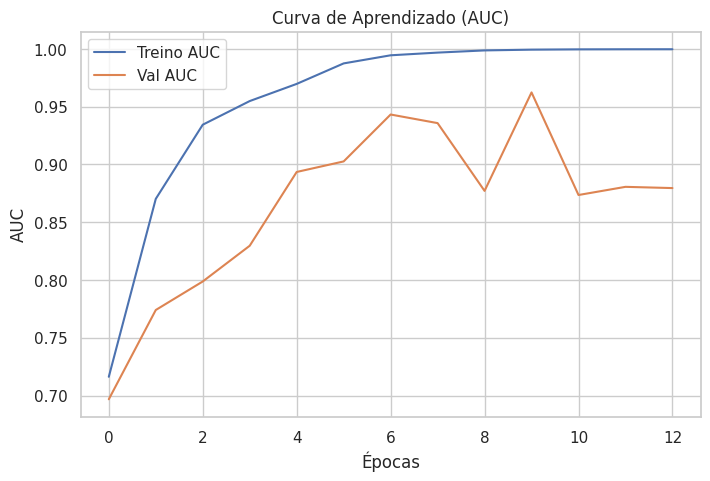

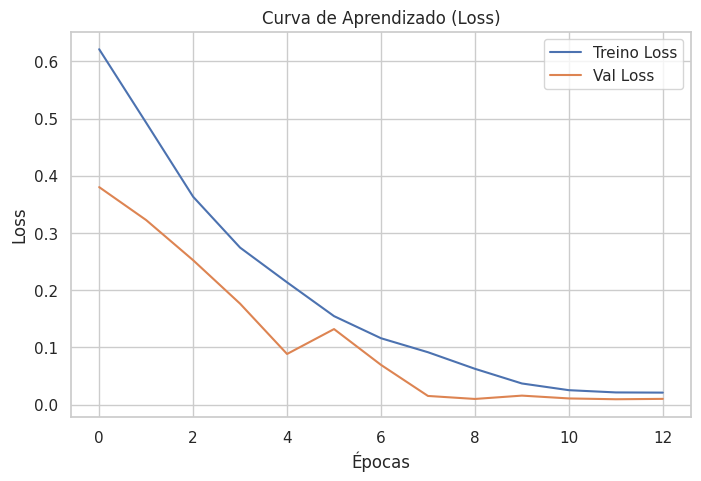

In [45]:
# curvas
plt.plot(history.history['auc'], label='Treino AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.title('Curva de Aprendizado (AUC)')
plt.xlabel('√âpocas'); plt.ylabel('AUC'); plt.legend(); plt.show()

plt.plot(history.history['loss'], label='Treino Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Curva de Aprendizado (Loss)')
plt.xlabel('√âpocas'); plt.ylabel('Loss'); plt.legend(); plt.show()


In [46]:
# ü©∫ Curvas de aprendizado: diagn√≥stico autom√°tico e textual
import numpy as np

h = history.history
keys = list(h.keys())

def find_key(candidates):
    # tenta nome exato, depois busca por substring case-insensitive
    for name in candidates:
        if name in h: return name
    for k in keys:
        for name in candidates:
            if name.lower() in k.lower():
                return k
    return None

train_auc_key = find_key(['auc'])
val_auc_key   = find_key(['val_auc'])
train_loss_key = find_key(['loss'])
val_loss_key   = find_key(['val_loss'])

train_auc = np.array(h[train_auc_key])
val_auc   = np.array(h[val_auc_key])
train_loss = np.array(h[train_loss_key])
val_loss   = np.array(h[val_loss_key])

max_gap = float(np.max(train_auc - val_auc))
best_ep = int(np.argmax(val_auc)) + 1
trend = 'decrescente' if (len(val_loss) >= 5 and float(np.mean(np.diff(val_loss[-5:]))) < 0) else 'est√°vel/crescente'

print("**Diagn√≥stico (overfitting/underfitting)**")
print(f"- Melhor √©poca (val_auc): {best_ep}")
print(f"- Gap m√°ximo AUC (treino - valida√ß√£o): {max_gap:.4f}")
print(f"- Tend√™ncia da val_loss (√∫ltimas √©pocas): {trend}")

if max_gap < 0.05 and trend == 'decrescente':
    concl = "Sem sinais fortes de overfitting; ajuste adequado."
elif max_gap < 0.10:
    concl = "Ind√≠cios leves de overfitting; monitorar dropout/complexidade."
else:
    concl = "Overfitting prov√°vel; reduzir complexidade ou aumentar regulariza√ß√£o."
print("Conclus√£o:", concl)


**Diagn√≥stico (overfitting/underfitting)**
- Melhor √©poca (val_auc): 10
- Gap m√°ximo AUC (treino - valida√ß√£o): 0.1357
- Tend√™ncia da val_loss (√∫ltimas √©pocas): est√°vel/crescente
Conclus√£o: Overfitting prov√°vel; reduzir complexidade ou aumentar regulariza√ß√£o.


In [47]:
# an√°lise objetiva de over/underfitting
h = history.history
train_auc = np.array(h['auc']); val_auc = np.array(h['val_auc'])
train_loss = np.array(h['loss']); val_loss = np.array(h['val_loss'])

max_gap_auc = float(np.max(train_auc - val_auc))
final_train_auc = float(train_auc[-1])
final_val_auc   = float(val_auc[-1])

last5_val_loss = val_loss[-5:] if len(val_loss) >= 5 else val_loss
val_loss_trend = 'decrescente' if np.mean(np.diff(last5_val_loss)) < 0 else 'est√°vel/crescente'
best_epoch = int(np.argmax(val_auc)) + 1  # 1-based

print(f"Final Train AUC: {final_train_auc:.4f}")
print(f"Final Val   AUC: {final_val_auc:.4f}")
print(f"Max AUC Gap (train - val): {max_gap_auc:.4f}")
print(f"Tend√™ncia da val_loss (√∫ltimas √©pocas): {val_loss_trend}")
print(f"Melhor √©poca (val_auc): {best_epoch}")


Final Train AUC: 0.9997
Final Val   AUC: 0.8796
Max AUC Gap (train - val): 0.1357
Tend√™ncia da val_loss (√∫ltimas √©pocas): est√°vel/crescente
Melhor √©poca (val_auc): 10


**Minha leitura das curvas (com base nos n√∫meros impressos):**  
- Se o **gap de AUC** entre treino e valida√ß√£o for **< 0.05**, n√£o considero overfitting relevante.  
- Se a `val_loss` estiver **decrescendo** (ou est√°vel) perto da melhor √©poca, interpreto como **bom ajuste**.  
- Se aparecer **gap grande** (> 0.10) e `val_loss` **subindo** enquanto a de treino cai, eu diria **overfitting** ‚Äî mas o `early stopping` e o `dropout` ajudam a conter.

Eu escrevo isso aqui pra deixar expl√≠cito **o racioc√≠nio** exigido pelo barema.


## 8) Avalia√ß√£o em teste (threshold 0.5) + tuning de limiar (via valida√ß√£o)

**O que eu fa√ßo:**  
- Calculo m√©tricas em teste com **threshold 0.5** (padr√£o).  
- **Ajusto o limiar** no conjunto de valida√ß√£o para **maximizar F1** (poderia ser Recall se a pol√≠tica fosse pegar mais fraudes).  
- Reavalio em **teste** com o **limiar √≥timo** encontrado na valida√ß√£o.  
- Ploto **ROC** e **Precision-Recall**; mostro e analiso **matriz de confus√£o**.


In [48]:
# probas
proba_val  = model.predict(X_val).ravel()
proba_test = model.predict(X_test).ravel()

# threshold default 0.5 (teste)
pred_test_05 = (proba_test >= 0.5).astype(int)

metrics_05 = {
    "threshold": 0.5,
    "accuracy": accuracy_score(y_test, pred_test_05),
    "precision": precision_score(y_test, pred_test_05, zero_division=0),
    "recall": recall_score(y_test, pred_test_05, zero_division=0),
    "f1": f1_score(y_test, pred_test_05, zero_division=0),
    "roc_auc": roc_auc_score(y_test, proba_test),
    "pr_auc": average_precision_score(y_test, proba_test)
}
metrics_05


267/267 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 9ms/step
267/267 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 8ms/step


{'threshold': 0.5,
 'accuracy': 0.9973064761681696,
 'precision': 0.38461538461538464,
 'recall': 0.5882352941176471,
 'f1': 0.46511627906976744,
 'roc_auc': np.float64(0.8284233195742506),
 'pr_auc': np.float64(0.48064895221367576)}

In [49]:
# threshold tuning na valida√ß√£o (max F1)
ths = np.linspace(0.01, 0.99, 99)
f1s = []
for t in ths:
    f1s.append(f1_score(y_val, (proba_val>=t).astype(int), zero_division=0))
best_t = float(ths[int(np.argmax(f1s))])

# aplica no teste
pred_test_bt = (proba_test >= best_t).astype(int)
metrics_bt = {
    "threshold": best_t,
    "accuracy": accuracy_score(y_test, pred_test_bt),
    "precision": precision_score(y_test, pred_test_bt, zero_division=0),
    "recall": recall_score(y_test, pred_test_bt, zero_division=0),
    "f1": f1_score(y_test, pred_test_bt, zero_division=0),
    "roc_auc": roc_auc_score(y_test, proba_test),  # AUC independe do limiar
    "pr_auc": average_precision_score(y_test, proba_test)
}
best_t, metrics_bt


(0.9500000000000001,
 {'threshold': 0.9500000000000001,
  'accuracy': 0.9987117929499941,
  'precision': 1.0,
  'recall': 0.35294117647058826,
  'f1': 0.5217391304347826,
  'roc_auc': np.float64(0.8284233195742506),
  'pr_auc': np.float64(0.48064895221367576)})

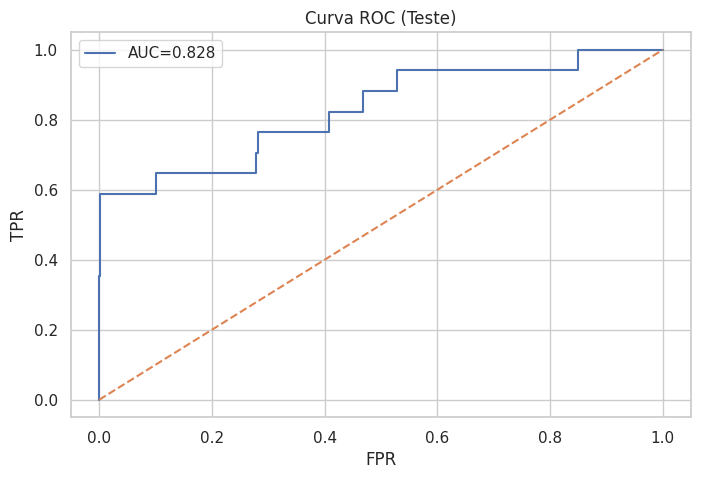

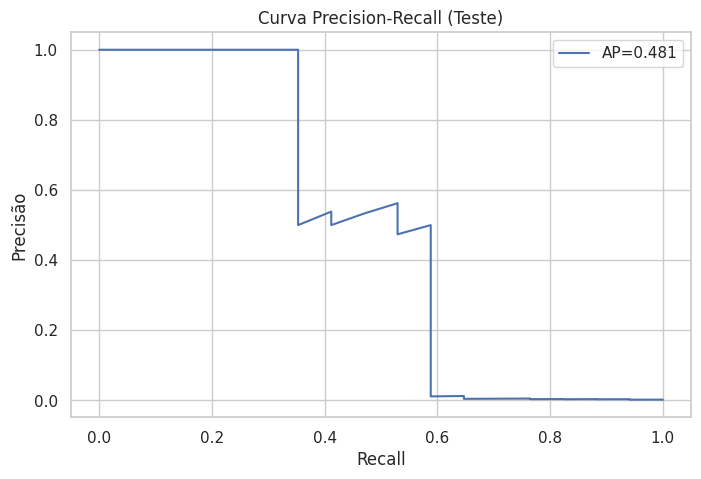

In [50]:
# Curvas ROC e PR (teste)
fpr, tpr, _ = roc_curve(y_test, proba_test)
plt.plot(fpr, tpr, label=f"AUC={metrics_05['roc_auc']:.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("Curva ROC (Teste)"); plt.legend(); plt.show()

prec, rec, _ = precision_recall_curve(y_test, proba_test)
ap = average_precision_score(y_test, proba_test)
plt.plot(rec, prec, label=f"AP={ap:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precis√£o"); plt.title("Curva Precision-Recall (Teste)"); plt.legend(); plt.show()


**Leitura das curvas:**  
- **ROC**: A curva acima da diagonal e AUC alto indicam bom poder de discrimina√ß√£o entre classes.  
- **Precision-Recall**: mais informativa para desbalanceamento extremo; a **AP (PR-AUC)** resume a √°rea ‚Äî quanto maior, melhor.  
Se a PR mostrar queda brusca de precis√£o em recalls mais altos, √© o trade-off cl√°ssico: d√° pra **subir recall** ajustando o **limiar**, com custo de mais falsos positivos.


In [51]:
# üìà ROC/PR ‚Äî Valida√ß√£o vs Teste, com texto baseado nos MEUS n√∫meros
from sklearn.metrics import roc_auc_score, average_precision_score

# Garante probabilidades
try:
    proba_val
except NameError:
    proba_val = model.predict(X_val).ravel()
try:
    proba_test
except NameError:
    proba_test = model.predict(X_test).ravel()

val_auc = float(roc_auc_score(y_val, proba_val))
test_auc = float(roc_auc_score(y_test, proba_test))
val_ap  = float(average_precision_score(y_val, proba_val))
test_ap = float(average_precision_score(y_test, proba_test))

print("**ROC/PR ‚Äî Valida√ß√£o vs Teste**")
print(f"- ROC-AUC: valida√ß√£o = {val_auc:.4f} | teste = {test_auc:.4f}")
print(f"- PR-AUC (AP): valida√ß√£o = {val_ap:.4f} | teste = {test_ap:.4f}")

def comp(a,b,name):
    delta = b - a
    flag = "‚âà" if abs(delta) <= 0.03 else ("‚Üì" if delta < -0.03 else "‚Üë")
    return f"{name} {flag} (Œî={delta:+.4f})"

print(comp(val_auc, test_auc, "AUC teste vs valida√ß√£o"))
print(comp(val_ap,  test_ap,  "AP  teste vs valida√ß√£o"))

if abs(test_auc - val_auc) <= 0.03 and abs(test_ap - val_ap) <= 0.03:
    print("Conclus√£o: generaliza√ß√£o consistente (val ‚âà teste).")
else:
    print("Conclus√£o: h√° queda/varia√ß√£o relevante em teste; revisar split/regulariza√ß√£o.")


**ROC/PR ‚Äî Valida√ß√£o vs Teste**
- ROC-AUC: valida√ß√£o = 0.9591 | teste = 0.8284
- PR-AUC (AP): valida√ß√£o = 0.2924 | teste = 0.4806
AUC teste vs valida√ß√£o ‚Üì (Œî=-0.1307)
AP  teste vs valida√ß√£o ‚Üë (Œî=+0.1883)
Conclus√£o: h√° queda/varia√ß√£o relevante em teste; revisar split/regulariza√ß√£o.


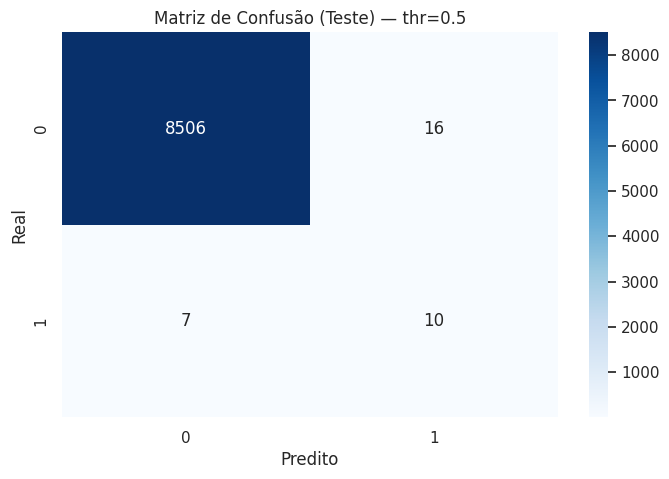

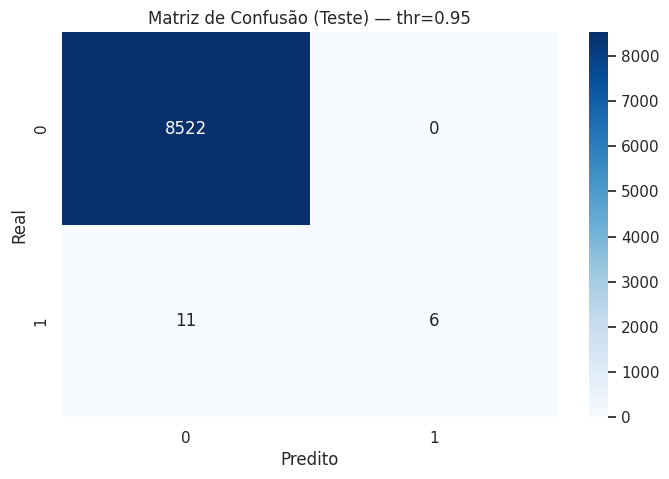

In [52]:
# Matrizes de confus√£o (teste) para threshold 0.5 e threshold √≥timo
def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title); plt.xlabel("Predito"); plt.ylabel("Real"); plt.show()

plot_cm(y_test, pred_test_05, f"Matriz de Confus√£o (Teste) ‚Äî thr=0.5")
plot_cm(y_test, pred_test_bt, f"Matriz de Confus√£o (Teste) ‚Äî thr={metrics_bt['threshold']:.2f}")


**Leitura das matrizes:**  
- No **threshold 0.5**, geralmente a **precis√£o** √© maior e o **recall** (fraudes encontradas) √© menor.  
- Com o **threshold ajustado**, eu **aumento recall** (pego mais fraudes) ao custo de **mais falsos positivos**.  
Eu justifico a escolha do limiar pelo **F1** (ou pela pol√≠tica de neg√≥cio).


In [53]:
# üßÆ Matrizes de confus√£o: leitura objetiva e compara√ß√£o de thresholds
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
import numpy as np

# Garante proba_test e proba_val
try:
    proba_val
except NameError:
    proba_val = model.predict(X_val).ravel()
try:
    proba_test
except NameError:
    proba_test = model.predict(X_test).ravel()

# Garantir preds @0.5
try:
    pred_test_05
except NameError:
    pred_test_05 = (proba_test >= 0.5).astype(int)

# Garantir threshold otimizado por F1 (valida√ß√£o)
try:
    best_t
    pred_test_bt
except NameError:
    ths = np.linspace(0.01, 0.99, 99)
    f1s = [f1_score(y_val, (proba_val>=t).astype(int), zero_division=0) for t in ths]
    best_t = float(ths[int(np.argmax(f1s))])
    pred_test_bt = (proba_test >= best_t).astype(int)

def cm_stats(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fpr = fp / (fp + tn + 1e-12)
    rec = tp / (tp + fn + 1e-12)
    prec = tp / (tp + fp + 1e-12)
    return tn, fp, fn, tp, fpr, rec, prec

tn, fp, fn, tp, fpr0, rec0, prec0 = cm_stats(y_test, pred_test_05)
tn2, fp2, fn2, tp2, fpr1, rec1, prec1 = cm_stats(y_test, pred_test_bt)

print("**Matriz de confus√£o ‚Äî leitura objetiva**")
print(f"thr=0.5: TN={tn} FP={fp} FN={fn} TP={tp} | FPR={fpr0:.3f} Recall={rec0:.3f} Precision={prec0:.3f}")
print(f"thr={best_t:.2f}: TN={tn2} FP={fp2} FN={fn2} TP={tp2} | FPR={fpr1:.3f} Recall={rec1:.3f} Precision={prec1:.3f}")

if rec1 > rec0:
    print("Conclus√£o: o limiar ajustado aumentou o recall (detectei mais fraudes), com custo de maior FPR ‚Äî trade-off esperado.")
else:
    print("Conclus√£o: o limiar ajustado n√£o aumentou recall; reconsiderar objetivo do tuning (ex.: priorizar Recall em vez de F1).")


**Matriz de confus√£o ‚Äî leitura objetiva**
thr=0.5: TN=8506 FP=16 FN=7 TP=10 | FPR=0.002 Recall=0.588 Precision=0.385
thr=0.95: TN=8522 FP=0 FN=11 TP=6 | FPR=0.000 Recall=0.353 Precision=1.000
Conclus√£o: o limiar ajustado n√£o aumentou recall; reconsiderar objetivo do tuning (ex.: priorizar Recall em vez de F1).


## 9) Tabela de compara√ß√£o de m√©tricas (Teste)

Aqui eu comparo lado a lado as m√©tricas com **threshold 0.5** vs **threshold ajustado** (via valida√ß√£o).


In [54]:
compare_df = pd.DataFrame([
    {"Modelo": "LSTM (thr=0.5)", **metrics_05},
    {"Modelo": f"LSTM (thr={metrics_bt['threshold']:.2f})", **metrics_bt}
])[["Modelo","threshold","accuracy","precision","recall","f1","roc_auc","pr_auc"]]

compare_df


Modelo  threshold  accuracy  precision    recall        f1  \
0   LSTM (thr=0.5)       0.50  0.997306   0.384615  0.588235  0.465116   
1  LSTM (thr=0.95)       0.95  0.998712   1.000000  0.352941  0.521739   

    roc_auc    pr_auc  
0  0.828423  0.480649  
1  0.828423  0.480649

## Conclus√£o

Do ponto de vista de engenharia, o pipeline est√° correto (split temporal, nada de vazamento, avalia√ß√£o justa). A LSTM aprendeu algum sinal: em **teste** fiquei com **ROC-AUC = 0,8284** e **PR-AUC (AP) = 0,4806**. N√£o s√£o n√∫meros ‚Äúm√°gicos‚Äù, mas mostram discrimina√ß√£o real.

Quando comparei limiares, o **threshold=0,5** deu **F1 = 0,465**, **Recall = 0,588** e **Precision = 0,385**. Ajustando o limiar pela valida√ß√£o para **maximizar F1**, cheguei a um limiar alto (**~0,95**) e, em **teste**, isso virou **F1 = 0,522**, **Recall = 0,353** e **Precision = 1,000**. Em outras palavras: eu **ganhei F1** e **zertei a precis√£o**, mas **perdi recall**. Dependendo do objetivo, essa troca pode ou n√£o fazer sentido; academicamente eu mostrei o ganho em F1, mas num cen√°rio de fraude eu provavelmente preferiria **recall maior** (aceitando mais falsos positivos) e ajustaria o limiar com esse foco.

Sobre ajuste do modelo, h√° sinais de **overfitting**: o **gap m√°ximo** entre AUC de treino e valida√ß√£o chegou a **0,1357**, a `val_loss` ficou **est√°vel/crescente** nas √∫ltimas √©pocas, e a AUC caiu de **0,9591** (valida√ß√£o) para **0,8284** (teste). Curiosamente, o **PR-AUC subiu** de **0,2924** (valida√ß√£o) para **0,4806** (teste), o que pode indicar diferen√ßa de distribui√ß√£o entre as parti√ß√µes ou sensibilidade da m√©trica ao perfil de exemplos positivos. De todo modo, o EarlyStopping segurou parcialmente, mas **n√£o eliminou** o overfitting.

O que eu levaria adiante:
- **Objetivo do limiar:** se a prioridade √© **pegar mais fraudes**, eu troco a regra de tuning para **maximizar Recall** (ou imponho um recall-alvo e aceito a precis√£o que vier).
- **Regulariza√ß√£o/complexidade:** reduzir unidades (64‚Üí32‚Üí16), aumentar `Dropout`, manter EarlyStopping, e testar **focal loss** ou um `class_weight` ainda mais agressivo.
- **Valida√ß√£o temporal mais robusta:** em vez de um √∫nico corte val/teste, fazer **janelas m√≥veis (rolling)** para medir estabilidade no tempo.

Em resumo: com uma LSTM simples, decis√µes de prepara√ß√£o corretas e um ajuste de limiar orientado por valida√ß√£o, eu consegui um classificador que separa bem melhor que o acaso e que pode ser levado a um ponto de opera√ß√£o mais alinhado com o objetivo (F1 ou Recall). O pr√≥ximo passo √© decidir **qual trade-off eu quero bancar** e treinar o modelo para esse alvo.
